Primero importamos todas las librerías a utilizar y creamos un objeto Trainset

In [8]:
from trainset import Trainset
import dataset_manager
from fileinput import close
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


myTrainset = Trainset()

Seteamos los valores para el entrenamiento del modelo

In [9]:
myTrainset.fecha_inicio_dataset= "2015-01-01"
myTrainset.fecha_fin_dataset= "2015-12-31"
myTrainset.cantidad_dias_hacia_atras = 4
myTrainset.porcentaje_entrenamiento = 0.7
myTrainset.porcentaje_validacion = 0.15
myTrainset.porcentaje_test = 0.15

Obtenemos el dataset junto con los conjuntos de entrenamiento, validación y testeo ya divididos.

In [10]:
training_days, validation_days, test_days = dataset_manager.getDataset(myTrainset)

/home/piche/Facultad/InteligenciaComputacional/nasdaq-index-rn/src/dataset_manager.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return filtered_dataset.append(days_before_first_day)


Separamos los valores de cierre, seno del día de la semana y coseno del día de la semana en 3 listas. Tambien creamos listas para setear las inputs y outputs a utilizar en el entrenamiento.
Seteamos las inputs del output y entrenamiento. Cada input esta formado por una lista con los siguientes valores: 
* Valor de cierre para los _n_ días anteriores al entrenamiento.
* El valor de seno para el día de la semana a predecir.
* El valor del coseno para el día de la semana a predecir.

También, para la salida del entrenamiento generamos una lista de listas, donde cada sublista tiene el valor de cierre para el día a predecir.

In [11]:
training_inputs, training_outputs = dataset_manager.generateTrainingIOs(training_days, myTrainset.dias_hacia_atras)
validation_inputs, validation_outputs = dataset_manager.generateTrainingIOs(validation_days, myTrainset.dias_hacia_atras)
test_inputs, test_outputs = dataset_manager.generateTrainingIOs(test_days, myTrainset.dias_hacia_atras)

Una vez tenemos las inputs y outputs a utilizar en el modelo, creamos este seteando sus distintos parámetros.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, input_dim=6, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(100, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(50, activation=tf.keras.activations.relu))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='mean_squared_error',
    metrics=['mae']
)

print("Resumen del modelo:")
print(model.summary())
print("Comenzando entrenamiento...")
historial = model.fit(training_inputs, training_outputs, epochs=100 ,verbose=1, validation_data=(validation_inputs, validation_outputs))
print("Modelo entrenado!")
print("Guardando modelo...")
model.save('models/model.h5', historial)

Cargamos el modelo guardado

In [12]:
print("Cargando modelo...")
model = tf.keras.models.load_model('models/modeloCool.h5')

Cargando modelo...


Ahora realizamos predicciones sobre el conjunto de testing y creamos un Dataset con los valores reales y la fecha.

In [13]:
predictions = [item for sublist in model.predict(test_inputs) for item in sublist]
results_df = pd.DataFrame(columns=['Date', 'Prediction', 'RealValue'])
results_df["Date"] = test_days["Date"].iloc[myTrainset.dias_hacia_atras:].apply(lambda row: (pd.to_datetime(row)).strftime("%Y-%m-%d"))
results_df["RealValue"] = test_days["Close"].iloc[myTrainset.dias_hacia_atras:]
results_df["Prediction"] = predictions


2/2 [==============================] - 0s 3ms/step


Finalmente graficamos los resultados

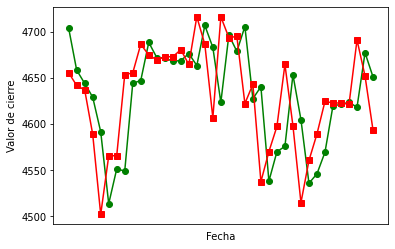

In [14]:
plt.plot(results_df["Prediction"], marker='o', color='green')
plt.xlabel("Fecha")
plt.xticks(ticks=range(0,len(results_df)), labels=results_df["Date"], rotation=90)
plt.ylabel("Valor de cierre")
plt.plot(results_df["RealValue"], marker="s", color='red')
plt.show()